In [ ]:
!pip install -U portalocker>=2.0.0

## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import itertools
import json
import pandas as pd

In [ ]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize data to range [-1, 1]
])
# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Training and Testing loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 14660770.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 309707.10it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5585329.74it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1182296.28it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

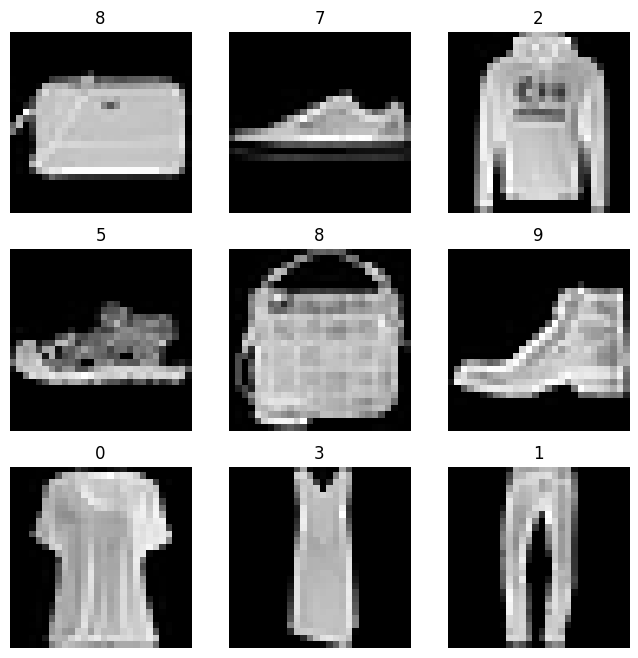

In [ ]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Neural network architecture
class MLP(nn.Module):
    #def __init__(self, hidden1=32, hidden2=32, hidden3=16):
    #def __init__(self, hidden1=32, hidden2=32):
    def __init__(self, hidden1=16, hidden2=16, hidden3=16):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 10)
        #self.fc5 = nn.Linear(hidden4, 10)


    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten image
        x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc2(x))  # First layer activation
        x = torch.tanh(self.fc3(x))
        #x = torch.tanh(self.fc4(x))     # Second layer activation
        x = self.fc4(x)                 # Output layer
        return x

Finished Training for config (180, 64, 64): Final Accuracy 72.19%


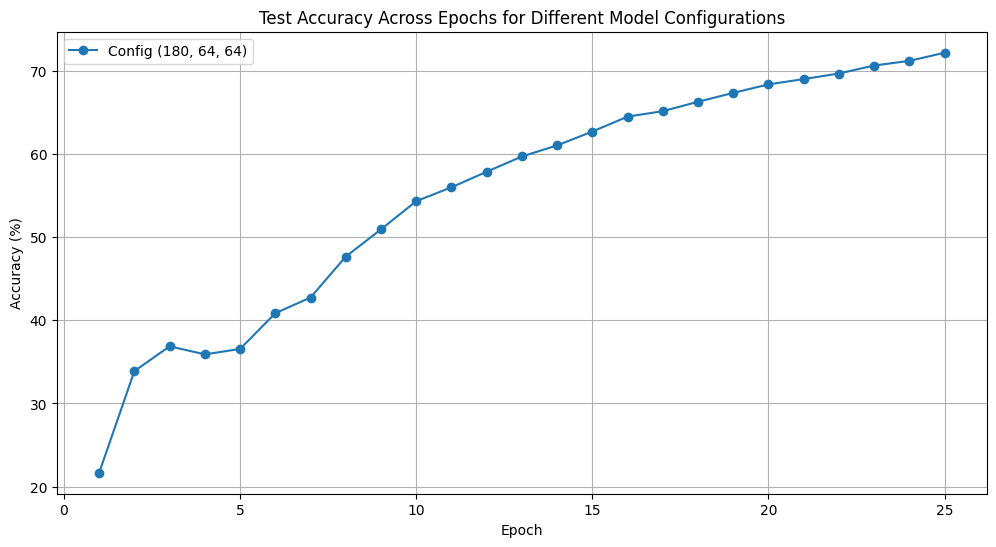

In [ ]:

# Training parameters
num_epochs = 25
model_configs = [(180, 64, 64)]
epoch_accuracies = {str(cfg): [] for cfg in model_configs}

for config in model_configs:
    model = MLP(*config)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        epoch_accuracies[str(config)].append(accuracy)
    print(f'Finished Training for config {config}: Final Accuracy {accuracy:.2f}%')

# Plotting results
plt.figure(figsize=(12, 6))
for config, accuracies in epoch_accuracies.items():
    plt.plot(range(1, num_epochs+1), accuracies, marker='o', linestyle='-', label=f'Config {config}')

plt.title('Test Accuracy Across Epochs for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation fucntion:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## CNN Implimentation with Keras

In [ ]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, RMSprop
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [ ]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
def create_model(num_layers=2, units_per_layer=128, activation='relu'):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation=activation))

    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
num_layers = 6
units_per_layer = 256
activation = 'relu'
learning_rate = 0.01
epochs = 75
batch_size = 48

# Create the model
model = create_model(num_layers=num_layers, units_per_layer=units_per_layer, activation=activation)

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

In [ ]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

In [ ]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=25)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/25
 227/1875 [==>...........................] - ETA: 41s - loss: 2.3028 - accuracy: 0.1016

KeyboardInterrupt: 

## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams